In [1]:
import numpy as np 
import matplotlib.pyplot as plt

from sklearn import linear_model
import statsmodels.formula.api as sm

from tqdm import tqdm
# for my supacool dark theme:
plt.style.use('dark_background')

## Real data

In [2]:
path2data= ''
'''A_raw = pd.readcsv(path2data + )
x_raw =prd.readcsv(path2data + )
y_raw =prd.readcsv(path2data + )'''

'A_raw = pd.readcsv(path2data + )\nx_raw =prd.readcsv(path2data + )\ny_raw =prd.readcsv(path2data + )'

## Simulated data

In [27]:
# simul_data:
# return a random sample of  coefficients with s 
## Input: n, p, eventually a MAF (Minor Allel Frequency) vector 
## output A, the genotype matrix
def simul_data(n, p=500, maf=None, miss = 0., miss_value='average'):
    '''
    Simulate the matrix A
    '''
    A = []
    if maf is None:
        maf = np.random.uniform(low=0.1, high=0.5, size = (1, p))
        
    for _ in range(n):
        A.append(np.random.binomial(2, maf)[0])
    A = np.array(A)
    st = A.std(axis=0)
    m = A.mean(axis=0)
    A = (A-m)/(st)
    
    return A
# With MAF    
# B = simul_data(1000, 10, maf=maf)

In [37]:
'''# Simulate Phenotype y given a genotype matrix A
Input:  A, genotype matrix (either real or simulated data)
        s, sparsity of the x vector (number of non zeros coeffs)
        h2, heritability (ratio of the phenotype explained by the genotype)
        xtype, in ['uniform', 'hyperExp'(not coded yet)], type of coefficients simulated 
'''
def genPhenotype(A, s, h2 = 1, xtype = 'uniform'):
    
    assert xtype in ['uniform', 'hyperExp'], 'Error, xtype should be "uniform" or "hyperExps"'
    
    n = A.shape[0]
    p = A.shape[1]
    x = np.random.uniform(-1,1,p)
    
    if xtype == 'hyperExp':
        x = np.exp(-(np.arange(p) + 1) / (.05*s)) + np.exp(-(np.arange(p)+1)/p)
    # set s coefficients to zeros
    x_mask = np.random.choice(np.arange(p), p-s, replace= False)
    x[x_mask] = 0
    # heritability
    x = np.sqrt(h2) * x / np.std(A.dot(x))
    e = np.sqrt(1-h2) * np.random.normal(n)
    y = A.dot(x) + e
    return x, y

#genPhenotype(At, st)

## Recovery algorithm: Linear regression with Lasso

We solve the following minimisation problem using scikit-learn : 
$$min_x [\Vert y -Ax \Vert_{L_2}^2+\lambda \Vert x \Vert_{L_1}]$$

In [38]:
def lasso(A, y, lambd = 0.1, normalize = True):
    """return the coefficient of the lasso regression of A over y, lambd is the regulizer parameter
    """
    reg = linear_model.Lasso(lambd*2*A.shape[0], normalize = normalize)
    reg.fit(A, y)
    return reg.coef_

## Recovery measures:

We implemented the different recovery measures developped in the paper:

* **PPV**, Positive Predicted Value: the ratio between the number of True Positive and the number of selected Positive coefficients (i.e. the number of non-zero coefficients: $\frac{\#\{x_i : x_i\neq 0;\hat x_i \neq 0\}}{\#\{\hat x_i:\hat x_i \neq 0\}}$

* **FPR**, False Positive Rate: the ratio between the number of False Positive and the total number of Negative coefficients (i.e. the number of zero coefficients): $\frac{\#\{x_i : x_i = 0;\hat x_i \neq 0\}}{\#\{x_i:x_i = 0\}}$ 

* **$med_{P-val}$**, the median of the P-values obtained when regressing the phenotypes on each selected SNP. For each of this regression, we compute the p-value associated to the t-test asserting if the coefficient of the regression is zero. We then take the median of these p-values. Note that, contrary to the other measures of recovery, this one could be computed in real experiments where we don't have access to the true coefficients x.

In [39]:
# positive predictive value
def PPV(x, x_hat):
    nb_tp = np.sum([1 for u,v in zip(x, x_hat) if (u != 0) and (v != 0)])
    nb_pos = np.sum([1 for e in x_hat if e!=0])
    assert nb_pos !=0, 'mError, x is null!'
    return nb_tp/nb_pos

def FPR(x, x_hat):
    nb_fp = np.sum([1 for u,v in zip(x, x_hat) if (u==0) and (v!=0)])
    nb_neg = np.sum([1 for e in x if e==0])
    if nb_neg ==0:
        print('FPR computation Warning, x is not sparse!')
        return -1
    return nb_fp/nb_neg

def med_P(x_hat, y, A, verbose = False):
    p_vals = []
    for i in np.arange(len(y)):
        if x_hat[i] != 0:
            snp = A[:,i]
            reg = sm.OLS(y, snp).fit()
            p_vals.append(reg.t_test([1]).pvalue) 
    measure = np.median(np.array(p_vals))
    if verbose:
        print('{} selected non zero coefficients (over {} total number of SNPs)'.format(len(p_vals), len(x_hat)))
    return measure

## Phase-transition 

In [40]:
# for the simulated assays
def phase_transition_mat(A, lambd = 0.1, h2 = 1, xtype = 'uniform', size = 20, recovery = False):
    """return return a size by size matrix with the NE score for the lasso reconstruction procedure 
    A : measurement matrix (genotype)
    h2: heritability (control the )
    size : the size of the phase transition matrix
    """
    # number of samples
    n = A.shape[0]
    # number of SNPs
    p = A.shape[1]
    PTM = 2*np.ones((size, size))
    ix = np.arange(n)
    
    if recovery:
        PPV_mat = np.zeros((size, size))
        FPR_mat = np.zeros((size, size))
        medP_mat = np.zeros((size, size))
    for j in tqdm(range(size)):
        n_step = p // size
        n_tmp = (j+1) * n_step
        delta = n_tmp/p
        # select eandomly a subset of individuals
        ix_tmp = np.random.choice(ix, n_tmp)
        for i in range(size):
            s_step = n_tmp // size
            s_tmp = (i+1) * s_step
            rho = s_tmp/n_tmp
            x, y = genPhenotype(A=A, s=s_tmp, h2=h2, xtype=xtype)                
            x_pred = lasso(A[ix_tmp,], y[ix_tmp], lambd = lambd)
            #print(delta*size, rho*size)
            if np.linalg.norm(x-x_pred)/np.linalg.norm(x) <= 1:
                #PTM[int(np.floor(rho*size-0.001)), int(np.floor(delta*size-0.001))] = np.linalg.norm(x-x_pred)/np.linalg.norm(x)
                PTM[i, j] = np.linalg.norm(x-x_pred)/np.linalg.norm(x)
            else:
                # big errors (>1) are marked as higher than 1
                PTM[i, j] = 1.5
            #print(rho, delta)
            if recovery:
                PPV_mat[i, j] = PPV(x, x_pred)
                FPR_mat[i, j] = FPR(x, x_pred)
                medP_mat[i, j] = med_P(x_pred, y, A)
                
    return PTM

In [41]:
# test purpose
nt = 100
pt = 500
At = simul_data(n = nt, p = pt)

In [50]:
PTM = phase_transition_mat(At, lambd = 0.00005, h2 = 1, xtype = 'hyperExp', recovery= False)
PTM[10]

100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


array([ 1.5       ,  0.98687672,  0.97030126,  0.92215392,  0.99524184,
        0.98269203,  0.99651993,  0.99349514,  1.5       ,  0.99943235,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ])

# Plot the matrix of transition

In [51]:
def frontier(mat, thres):
    """construction of the phase transition frontier, i.e. first time the NE score is below the thres value"""
    L = []
    N = len(mat)
    for s in range(int(N)):
        P = 0
        while mat[P,s]<thres and P<N-1:
            P = P + 1
        L.append(P)
    return L

In [52]:
def plot_transition(M, thres = 0.5, save = False):
    size = M.shape[0]
    #plt.figure(figsize=(8,8))
    #rho_min, rho_max, delta_min, delta_max = 0, size, 0, size
    fig = plt.imshow(M, interpolation="gaussian",  
                 aspect='auto', origin = 'lower', extent = [0, size, 0, size])
    plt.xlabel(r'$\delta = \frac{n}{p}$')
    plt.ylabel(r'$\rho = \frac{s}{n}$')

    #empirical phase transition
    X = range(size)
    L = frontier(M, thres = thres)
    plt.plot(X,L, linewidth=4, color = 'black', label='phase transition')
    plt.legend(loc=4)
    cax = plt.axes([1, 0.1, 0.075, 0.8])
    plt.colorbar(cax=cax)
    plt.show()
    if save == True:
        filename = 'transition_matrix.png'
        plt.savefig(filename,bbox_inches='tight')

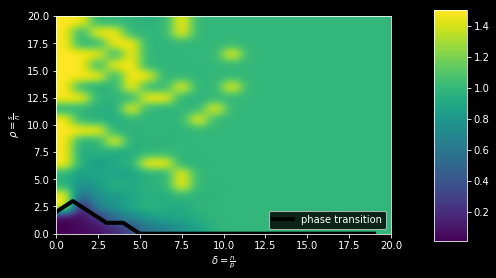

In [53]:
plot_transition(PTM)